In [1]:
import spacy
import random
import ast
import matplotlib.pyplot as plt
import pandas as pd
from spacy.training.example import Example
from spacy import displacy
import torch

# grab the file path and load csv into df
training_data_file_path = "/Users/shubham/Desktop/ner.csv"
df = pd.read_csv(training_data_file_path)

# get some stats
df.head()
df.describe()

# noticed there are a lot of duplicate sentences which dont make sense to be there so I remove duplicates
df2 = df.drop_duplicates(subset='Sentence')
df2.describe()
df2.head()


,Sentence #,Sentence,POS,Tag
0,Sentence: 1,Thousands of demonstrators have marched throug...,"['NNS', 'IN', 'NNS', 'VBP', 'VBN', 'IN', 'NNP'...","['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', '..."
1,Sentence: 2,Families of soldiers killed in the conflict jo...,"['NNS', 'IN', 'NNS', 'VBN', 'IN', 'DT', 'NN', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
2,Sentence: 3,They marched from the Houses of Parliament to ...,"['PRP', 'VBD', 'IN', 'DT', 'NNS', 'IN', 'NN', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
3,Sentence: 4,"Police put the number of marchers at 10,000 wh...","['NNS', 'VBD', 'DT', 'NN', 'IN', 'NNS', 'IN', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
4,Sentence: 5,The protest comes on the eve of the annual con...,"['DT', 'NN', 'VBZ', 'IN', 'DT', 'NN', 'IN', 'D...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."


In [3]:
'''
One thing to note here: is that this NER dataset that I found is split into the following columns:
    - Sentence #, Sentence, POS(Word type description, NOUN, etc..), Tag(O-per with IOB-named entity)
But spaCy doesn't understand the data in this format. spaCy understands data in the format of a tuple
    - (string, dict) where dict = {entities : [tuples of (start, end, entity)]}
So in order to train the model with spaCy like the paper suggests we first need to reformat df2 which is what the functions
below are all working together to do.

1st Function(taggedFormat(df2)): gives you a line of output like this while ignoring all the O blocks:
    - ({'entities': [(0, 4, 'B-gpe'), (12, 21, 'B-per'), (22, 29, 'I-per'), (30, 41, 'I-per'), (47, 54, 'B-tim'), (60, 68, 'B-gpe'), (100, 104, 'B-gpe'), (158, 165, 'B-gpe')]})

2nd Function(combineTaggedData(tagged_spacy_data)): looking at the above example notice how (12, 41) are all B,I,I-per, they are talking about the same named entity PER, so we need to combine these somehow to turn it into this
    - ({'entities': [(0, 4, 'B-gpe'), (12, 41, 'B-per'), (47, 54, 'B-tim'), (60, 68, 'B-gpe'), (100, 104, 'B-gpe'), (158, 165, 'B-gpe')]})

3rd Function(convertSpacyFormat(combined_spacy_data)). But when we make our training data we dont include the tags: 'B-', 'I-', etc.. and we also capitalize the 'per' -> 'PER' to follow a standard so we need to do some processing of this formatted data
and put in this form(using .upper() and [2:] we can do this):
    - {'entities': [(0, 4, 'GPE'), (12, 41, 'PER'), (47, 54, 'TIM'), (60, 68, 'GPE'), (100, 104, 'GPE'), (158, 165, 'GPE')]}

One of the main techniques the paper proposes is converting unstructured data into structured data so that spaCy can understand
it and to that we convert the data in this format here. The actual conversion process was not dicussed in the paper but the final
format was. The intermediary steps to convert to this format are what I came up with on my own.
'''

def taggedFormat(df):
    tagged_spacy_data = []
    for index, row in df.iterrows():
        sentence = row['Sentence']
        ner_tags = row['Tag']

        # right now here ner_tags is of type string, so in order to get the elements lets convert to a list
        ner_tags = ast.literal_eval(ner_tags)

        entities = []
        start = 0
        end = 0
        for tagIndex, word in enumerate(sentence.split()):
            end = start + len(word)

            if tagIndex >= len(ner_tags): 
                break
            if(ner_tags[tagIndex] != 'O'):
                entities.append((start, end, ner_tags[tagIndex]))

            start = end + 1
        
        if len(entities) > 0:
            tagged_spacy_data.append((sentence, {"entities": entities}))

    return tagged_spacy_data

def combineTaggedData(tagged_spacy_data):
    to_combine = []

    for sentence, entities_dict in tagged_spacy_data:
        entities_list = entities_dict["entities"]

        i = 0
        j = 1
        currArr = []
        found = False
        while j < len(entities_list):
            start1, end1, entity_type1 = entities_list[i]
            start2, end2, entity_type2 = entities_list[j]

            splitI = entity_type1.split('-')
            splitJ = entity_type2.split('-')

            if splitI[0] == 'B' and splitJ[0] == 'I':
                if j == len(entities_list) - 1:
                    currArr.append((start1, end2, entity_type1))
                    found = True
                j += 1
            else:
                _, endPrev, _ = entities_list[j-1]
                currArr.append((start1, endPrev, entity_type1))
                i = j
                j += 1
        
        if i == len(entities_list) - 1:
            currArr.extend(entities_list[i:])

        to_combine.append((sentence, {"entities" : currArr}))
    
    return to_combine

def convertSpacyFormat(to_combine):
    spacy_formatted_data = []

    for sentence, entities_dict in to_combine:

        entities_list = entities_dict["entities"]
        modified_entities = []

        for start, end, type in entities_list:
            currType = type
            formattedType = currType[2:].upper() # turn 'B-Geo' -> 'GEO' for example
            modified_entities.append((start, end, formattedType))
        
        spacy_formatted_data.append((sentence, {"entities" : modified_entities}))

    return spacy_formatted_data


# convert df2 to the spacy format but the the BIO tags are still there
spacy_training_data = taggedFormat(df2)

# combine the tag data so like [(4, 10, 'B-Org), (11, 14, 'I-Org')] becomes [(4, 14, 'B-Org')]
combined_spacy_data = combineTaggedData(spacy_training_data)

# remove the tags and now we are officially ready to train our model with the TRAINING_DATA we just created
TRAINING_DATA = convertSpacyFormat(combined_spacy_data)

print(df2.iloc[0])
print(TRAINING_DATA[6])


Sentence #                                          Sentence: 1
Sentence      Thousands of demonstrators have marched throug...
POS           ['NNS', 'IN', 'NNS', 'VBP', 'VBN', 'IN', 'NNP'...
Tag           ['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', '...
Name: 0, dtype: object
("The International Atomic Energy Agency is to hold second day of talks in Vienna Wednesday on how to respond to Iran 's resumption of low-level uranium conversion .", {'entities': [(4, 38, 'ORG'), (73, 79, 'GEO'), (80, 89, 'TIM'), (111, 115, 'GPE')]})


GEO Count: 37416
ORG Count: 20036
PER Count: 16895
GPE Count: 15815
TIM Count: 20232
ART Count: 402
EVE Count: 307
NAT Count: 197


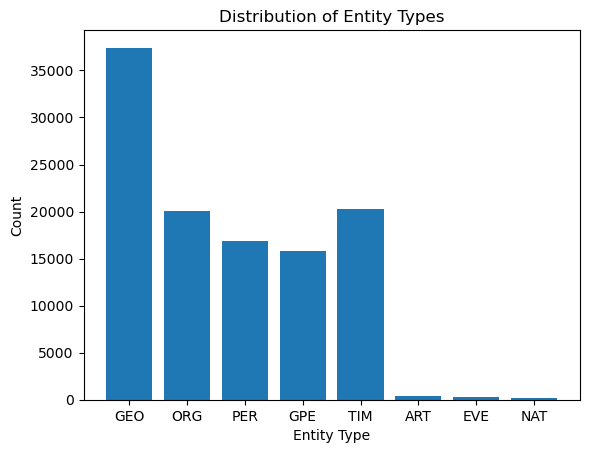

'\nAs I predicted here it appears that the number of GEO, is significantly higher than everything else and\nthat is very problematic so I need to fix this.\n'

In [5]:
'''
So when I initially trained versions of the model and used it in my chrome extension, one thing that I noticed was that 
my server kept extracting an ungodly amount of GEO entities so I wonder if the data is more scewed for GEO, 
so I am going to check that right now and see if I am correct.

8 entities: GEO, ORG, PER, GPE, TIME, ART, EVE, NAT
I want to count how often I see these and plot on a bar graph
'''
def findTagCountsInDataset(data_set):
    tagCountMap = {'GEO': 0, 'ORG': 0, 'PER': 0, 'GPE': 0, 'TIM': 0, 'ART': 0, 'EVE': 0, 'NAT': 0}

    for text, annotations in data_set:
        entities = annotations.get('entities', [])
        for _, _, tag in entities:
            if tag in tagCountMap:
                tagCountMap[tag] += 1

    # Display counts
    for tag, count in tagCountMap.items():
        print(f"{tag} Count: {count}")

    # Plotting
    tags = list(tagCountMap.keys())
    counts = list(tagCountMap.values())

    plt.bar(tags, counts)
    plt.xlabel('Entity Type')
    plt.ylabel('Count')
    plt.title('Distribution of Entity Types')
    plt.show()

findTagCountsInDataset(TRAINING_DATA)

'''
As I predicted here it appears that the number of GEO, is significantly higher than everything else and
that is very problematic so I need to fix this.
'''




This is the new copied_training_data; everything is the same but GEO should be 29416
GEO Count: 22416
ORG Count: 20036
PER Count: 16895
GPE Count: 15815
TIM Count: 20232
ART Count: 402
EVE Count: 307
NAT Count: 197


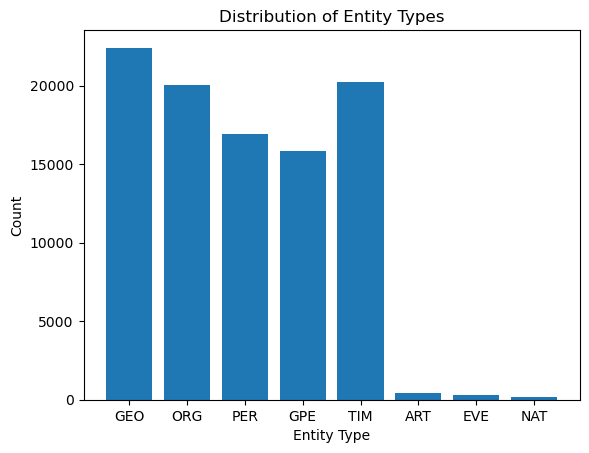

This should not change the TRAINING_DATA
GEO Count: 37416
ORG Count: 20036
PER Count: 16895
GPE Count: 15815
TIM Count: 20232
ART Count: 402
EVE Count: 307
NAT Count: 197


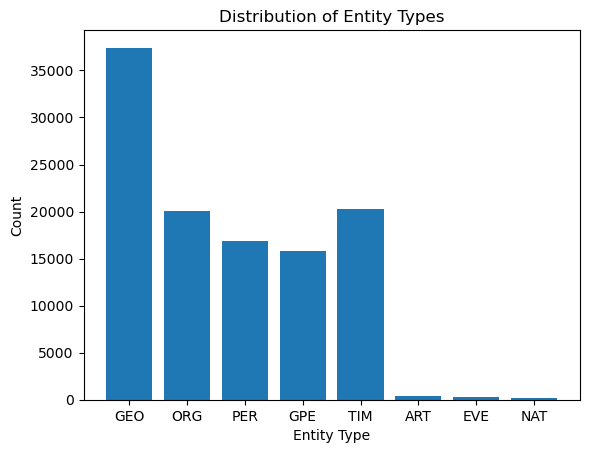

In [7]:
'''
We have so many GEO entities so I am basically going to scan this TRAINING_DATA pick random locations as in TRAINING_DATA[x]
and then I will scan that to see if there is GEO in there. If there is GEO I will the first GEO entity from that list that I find.
I will keep removing GEO's in this manner until I hit 8k GEO removals.
'''

# ('Iraqi against al Qaida in Iraq fighters .', {'entities': [(0, 5, 'GPE'), (80, 85, 'GEO'), (114, 130, 'ORG')]})

import numpy as np
import copy
import random

copied_training_data = copy.deepcopy(TRAINING_DATA)
possibleIndices = np.arange(len(copied_training_data))

totalGEORemovals = 15000

while totalGEORemovals > 0:
    randomIndex = np.random.choice(possibleIndices)
    sentence, annotations = copied_training_data[randomIndex]
    # print(randomIndex)
    for tple in annotations['entities']:
        start, end, label = tple
        if label == "GEO":
            # print(f"Initial Entities", annotations['entities'])
            # findTagCountsInDataset(copied_training_data)
            annotations['entities'].remove(tple)
            # print(f"After Removal Entities", annotations['entities'])
            # findTagCountsInDataset(copied_training_data)
            totalGEORemovals -= 1
            break

print("This is the new copied_training_data; everything is the same but GEO should be 22416")
findTagCountsInDataset(copied_training_data)

print("This should not change the TRAINING_DATA")
findTagCountsInDataset(TRAINING_DATA)


GEO Count: 17866
ORG Count: 16032
PER Count: 13494
GPE Count: 12578
TIM Count: 16143
ART Count: 332
EVE Count: 241
NAT Count: 153


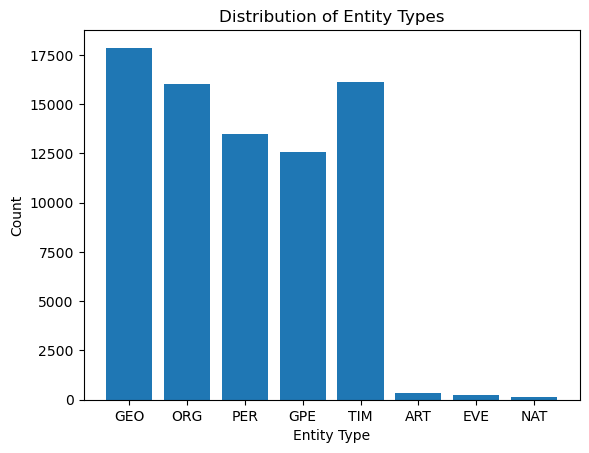

In [8]:
'''
So I am splitting the data into training data and evaluation data, and I will get the metrics of it after
80% training, 20% evaulation data that I will test on and gather F1 score and other metrics
'''

from sklearn.model_selection import train_test_split
new_training_data, evaluation_data = train_test_split(copied_training_data, test_size=0.2, random_state=42)
findTagCountsInDataset(new_training_data)

In [9]:
print(spacy.require_gpu())
print(torch.__version__)
# Check if GPU is available and set up the GPU device

if spacy.require_gpu():
    spacy.prefer_gpu()
    print("Using GPU")

nlp = spacy.blank("en")
ner = nlp.add_pipe("ner")

collected_training_data = []
for text, entity_map_item in new_training_data:
    converted_data = Example.from_dict(nlp.make_doc(text), entity_map_item)
    collected_training_data.append(converted_data)

nlp.begin_training()
for i in range(100):
    random.shuffle(collected_training_data)
    losses = {}
    for data in collected_training_data:
        nlp.update([data], drop=0.4, losses=losses)
    
    print(f"Epoch {i+1}, Losses: {losses}")


# save the model so that we have future access to it here
nlp.to_disk("FixedOverfittingLowerEpoch_custom_ner_model")

# Load the model
custom_ner_modl = spacy.load("FixedOverfittingLowerEpoch_custom_ner_model")

True
2.1.1
Using GPU
Epoch 1, Losses: {'ner': 66382.17051409482}
Epoch 2, Losses: {'ner': 56267.69201465321}
Epoch 3, Losses: {'ner': 54706.14419825815}
Epoch 4, Losses: {'ner': 54292.245142940184}
Epoch 5, Losses: {'ner': 53738.05377689524}
Epoch 6, Losses: {'ner': 53785.47079018109}
Epoch 7, Losses: {'ner': 53711.60373782739}
Epoch 8, Losses: {'ner': 53036.70921842791}
Epoch 9, Losses: {'ner': 53085.420383509394}
Epoch 10, Losses: {'ner': 53521.819384278395}
Epoch 11, Losses: {'ner': 53117.50250643522}
Epoch 12, Losses: {'ner': 53034.536193561515}
Epoch 13, Losses: {'ner': 52836.24093348}
Epoch 14, Losses: {'ner': 52848.653658417905}
Epoch 15, Losses: {'ner': 53017.53727936219}
Epoch 16, Losses: {'ner': 53076.43524954068}
Epoch 17, Losses: {'ner': 52767.14206906113}
Epoch 18, Losses: {'ner': 52717.86664021437}
Epoch 19, Losses: {'ner': 52443.59970682511}
Epoch 20, Losses: {'ner': 52966.85144493656}
Epoch 21, Losses: {'ner': 52984.329431305705}
Epoch 22, Losses: {'ner': 52942.63036533

In [40]:
# Evaluation Data contains all the testing stuff so lets get some metrics on that data first
evaluationDataLen = len(evaluation_data)
# print(evaluationDataLen)

# model_path = "/Users/shubham/ForwardDataLabTask1/FixedOverfitting_custom_ner_model"
# nlp = spacy.load(model_path)

all_model_paths = ["/Users/shubham/ForwardDataLabTask1/V5_custom_ner_model",
                   "/Users/shubham/ForwardDataLabTask1/FixedOverfitting_custom_ner_model",
                   "/Users/shubham/ForwardDataLabTask1/FixedOverfittingLowerEpoch_custom_ner_model",
                   "/Users/shubham/ForwardDataLabTask1/Latest_custom_ner_model",
                   "/Users/shubham/ForwardDataLabTask1/V4_custom_ner_model",
                   "/Users/shubham/ForwardDataLabTask1/task2_my_custom_ner_modelV2",
                   "/Users/shubham/ForwardDataLabTask1/task2_my_custom_ner_model",
                   "/Users/shubham/ForwardDataLabTask1/custom_ner_model"]

# 1. Find out the number of actual annoted entities from the data
# 2. Find out the number of predicted entities from the data that our model predicted

model_results = {}

for model_path in all_model_paths:
    nlp = spacy.load(model_path)
    model_name = model_path.split('/')[-1] # get everything after the last / since that is the model name

    ed_actualAnnotations = 0
    ed_predicted = 0

    for entry in evaluation_data:
        text, annotations = entry
        ed_actualAnnotations += len(annotations['entities'])
        doc = nlp(text)
        ed_predicted += len(doc.ents)
    
    td_actualAnnotations = 0
    td_predicted = 0
    for entry in new_training_data:
        text, annotations = entry
        td_actualAnnotations += len(annotations['entities'])
        doc = nlp(text)
        td_predicted += len(doc.ents)
    
    results = {'ed_metrics': [ed_actualAnnotations, ed_predicted], 'td_metrics': [td_actualAnnotations, td_predicted]}
    model_results[model_name] = results

for model_name, metrics in model_results.items():
    print(f"Model Name: {model_name}")
    print(f"General Evaluation Dataset metrics:    Actual Annotations: {metrics['ed_metrics'][0]}    Predicted Annotations: {metrics['ed_metrics'][1]}    The difference is {metrics['ed_metrics'][0] - metrics['ed_metrics'][1]}")
    print(f"General Training Dataset metrics:      Actual Annotations: {metrics['td_metrics'][0]}    Predicted Annotations: {metrics['td_metrics'][1]}    The difference is {metrics['td_metrics'][0] - metrics['td_metrics'][1]}")
    print("----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")


Model Name: V5_custom_ner_model
General Evaluation Dataset metrics:    Actual Annotations: 19461    Predicted Annotations: 17825    The difference is 1636
General Training Dataset metrics:      Actual Annotations: 76839    Predicted Annotations: 70653    The difference is 6186
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Model Name: FixedOverfitting_custom_ner_model
General Evaluation Dataset metrics:    Actual Annotations: 19461    Predicted Annotations: 19655    The difference is -194
General Training Dataset metrics:      Actual Annotations: 76839    Predicted Annotations: 78076    The difference is -1237
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [42]:
from spacy.training.example import Example
import random
import spacy
from spacy import displacy

sample_txt = "Albert Einstein was born at Ulm, in Württemberg, Germany, on March 14, 1879. Six weeks later the family moved to Munich, where he later on began his schooling at the Luitpold Gymnasium. Later, they moved to Italy and Albert continued his education at Aarau, Switzerland and in 1896 he entered the Swiss Federal Polytechnic School in Zurich to be trained as a teacher in physics and mathematics. In 1901, the year he gained his diploma, he acquired Swiss citizenship and, as he was unable to find a teaching post, he accepted a position as technical assistant in the Swiss Patent Office. In 1905 he obtained his doctor’s degree."

custom_ner_model_path = "/Users/shubham/ForwardDataLabTask1/FixedOverfitting_custom_ner_model"
nlp = spacy.load(custom_ner_model_path)
doc = nlp(sample_txt)
displacy.render(doc, style='ent')